# Simple benchmarking of Norway oil and gas deposits

This notebook is to show some visualisation of open source data (https://factpages.npd.no/) and make fast helicopter view analysis.
Here we will try to answer several questions: 

- what is the best deposit from economy point of view

- can we make any prediction about volume of production, depending on scale of deposit

- what deposit has the most productive wells 

- some others?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from parce_dat import import_csv
from scipy.interpolate import interp1d

C:\Users\zhuravlev.sd\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py:107: MatplotlibDeprecationWarning: 
The deprecated function was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  from . import _api, cbook, docstring, rcsetup


In [2]:
#importing prepared data from downloaded CSV files
prodData = import_csv()

C:\Users\zhuravlev.sd\Desktop\Баловство\NPD_bench\parce_dat.py:109: RuntimeWarning: invalid value encountered in true_divide
  tmp['ProductionWatPerc'] = 100*tmp['ProductionWat']/(tmp['ProductionWat']+tmp['Production'])


Lets visualize some relative metrics not to be connected directly to scale of deposit. Such metrics could be unit production (relation between production and initial resources) vs stage.

Text(0, 0.5, 'Oil production rate, %')

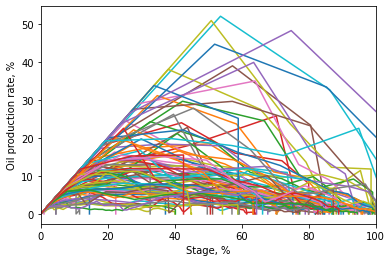

In [3]:
fig  = plt.figure()
for c_field in prodData:
    plt.plot(c_field['Stage'], c_field['UnitProd'])
plt.xlim([0,100])
plt.xlabel('Stage, %')
plt.ylabel('Oil production rate, %')

What we see here is that some deposits have huge oil production rate 20% and more on some stage. By common sense we can suppose that those deposits should have small initial oil resorces. Large deposits barely could support such high percentage. Lets check this.

We can create a surface where first axis is for initial resources, second is for stage and value is for oil production rate.

C:\Users\zhuravlev.sd\AppData\Local\Continuum\anaconda\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\zhuravlev.sd\AppData\Local\Continuum\anaconda\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


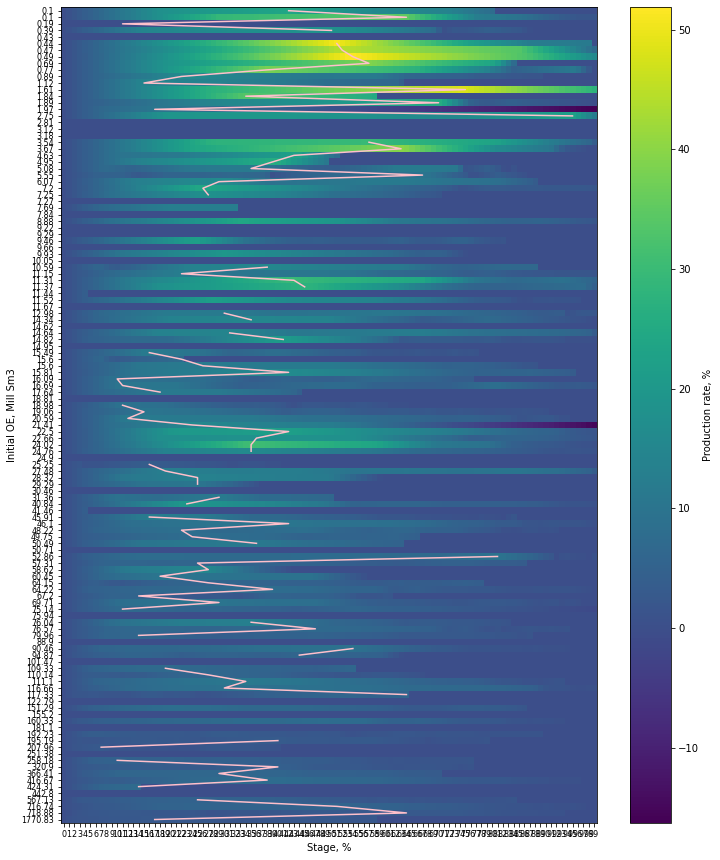

In [4]:
# Sort list of dicts for easier work
prodSort = sorted(prodData, key=lambda d: d['IniOE'])

# set surface dimension to store our data
# dimension 100 is to store values of production for stages from 0 to 100 with step in 1 percent
surf = np.zeros((len(prodSort), 100))
for i, el in enumerate(prodSort):
    tx = el['Stage']
    ty = el['UnitProd']
    f = interp1d(tx, ty, fill_value = 'extrapolate')
    nx = np.arange(0,100)
    ny = f(nx)
    surf[i,:] = ny

#filtering some bad values
surf[surf>999] = 0
surf[surf<-999] = 0
surf[np.isnan(surf)==True] = 0

max_pr = np.zeros(len(surf))*np.nan
for i in range(len(max_pr)):
    m_arg = np.argmax(surf[i,:])
    if m_arg>5:
        max_pr[i] = m_arg 

fig, ax = plt.subplots(figsize=(12,15))
# ext = [0, 100, prodSort[-1]['IniOE'], prodSort[0]['IniOE']]
# plt.imshow(surf, extent = ext, aspect='auto')
im = ax.imshow(surf, aspect='auto')
ax.plot(max_pr, np.arange(len(max_pr)), color = 'pink')
ax.set_xticks(np.arange(0,100))
ax.set_yticks(np.arange(len(prodSort)))
ax.set_yticklabels([el['IniOE'] for el in prodSort])
ax.tick_params(axis='both', labelsize = 8)
ax.set_xlabel('Stage, %')
ax.set_ylabel('Initial OE, Mill Sm3')
fig.colorbar(im, ax=ax, label='Production rate, %')

The figure represents that deposits with smaller initial oil resources could reach higher relative performance (up to 50% per stage). The production peaks for small deposits are situated closer to middle stages, than for bigger ones. The pink line traces production peaks for our deposit set (please note that vertical axis is not linear). Of course, such analysis should be done more accurate, for example we don't filter the origin of maximum value - is it real peak of production or deposit just did't get to point of its teoreticaly highest perfomance, but that's not our aim, we just want to explore some fundamental things.

Now, let's see if we can make a prediction of peak stage, using our dataset. We need to linearize values by x_axis to eliminate huge dynamic range of initial volume of deposit and build some trend line.

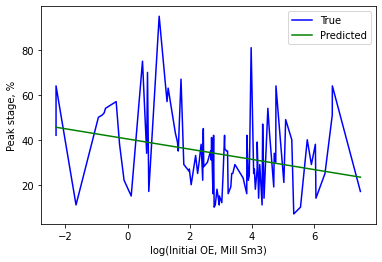

In [5]:
# filter nan values
yval = max_pr[np.where(max_pr>0)]
xval = np.log([el['IniOE'] for el in prodSort])[np.where(max_pr>0)]

model = np.polyfit(xval, yval, 1)
predict = np.poly1d(model)
new_x = np.linspace(xval[0], xval[-1])
trendline = predict(new_x)

plt.figure()
plt.plot(xval, yval, label = 'True', color = 'blue')
plt.plot(new_x, trendline, label = 'Predicted', color = 'green')
plt.xlabel('log(Initial OE, Mill Sm3)')
plt.ylabel('Peak stage, %')
plt.legend()

Now, why don't we take some known data and estimate if this trend-line could be used as a prediction function (as if don't see that it's not a pefect fit)?

In [6]:
cind = 44 #almost randomly taken index of deposit

true_stage = prodSort[cind]['Stage'][np.argmax(prodSort[cind]['UnitProd'])]
pred_stage = predict(np.log(prodSort[cind]['IniOE']))

print('True stage: '+str(true_stage))
print('Predicted stage: '+str(pred_stage))

True stage: 27.708333333333332
Predicted stage: 34.79964880482471


In this case difference in stages is 10%, which is not very accurate, but this is fast result we 
get just in several minutes not taking into account technologies, amount of wells and other impacting factors. Is it still so poor? 

Now, continue with some economical calculation. 

Text(0, 0.5, 'NOK cashflow')

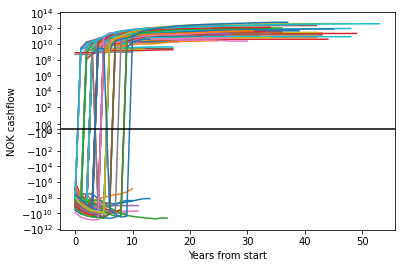

In [9]:
op = 7000 #oil price for old times in NOK
plt.figure()
for dep in prodSort:
    tot_inv = np.zeros_like(dep['Years'])
    tot_prof = np.zeros_like(dep['Years'])
    
    for i in range(len(tot_inv)):
        tot_inv[i] = -np.sum(dep['Investment'][:i+1])*1e+6
        tot_prof[i] = np.sum(dep['Production'][:i+1])*1e+6*0.84*op
    
    if np.sum(tot_inv)<0 and np.sum(tot_prof)>0:
        first_ind = np.min([np.min(np.where(dep['Investment']>0)[0]), np.min(np.where(dep['Production']>0)[0])])
        
        plt.plot(dep['Years'][first_ind:]-np.min(dep['Years'][first_ind:]), np.array(tot_prof+tot_inv)[first_ind:])
        plt.yscale('symlog')
plt.axhline(y=0, color = 'black')
plt.xlabel('Years from start')
plt.ylabel('NOK cashflow')

Here we don't take into account taxes, salaries of staff etc. Just fast estimation of total difference between investments and income from oil realization with fixed oil price. Even here we can see that many of deposits are on positive side of graphics, but some are on negative. Let's state some questions:

- what is the most effective deposit in our days?
- what is the least effective deposit in our days?
- what is correlation between size of deposit and years needed to be spend to get positive value?

In [10]:
op = 7000 #oil price for old times in NOK
econ_list = []
for dep in prodSort:
    tot_inv = np.zeros_like(dep['Years'])
    tot_prof = np.zeros_like(dep['Years'])
    
    for i in range(len(tot_inv)):
        tot_inv[i] = -np.sum(dep['Investment'][:i+1])*1e+6
        tot_prof[i] = np.sum(dep['Production'][:i+1])*1e+6*0.84*op
    
    if np.sum(tot_inv)<0 and np.sum(tot_prof)>0:
        eff = -(tot_prof[-1]+tot_inv[-1])/tot_inv[-1]
        cash_flow = np.array(tot_prof+tot_inv)
        first_ind = np.min([np.min(np.where(dep['Investment']>0)[0]), np.min(np.where(dep['Production']>0)[0])])
        
        tmp = {}        
        tmp['Field'] = dep['Field']
        tmp['EconEff'] = eff
        tmp['IniOE'] = dep['IniOE']
        
        pos_ind = np.where(cash_flow>0)[0]
        if len(pos_ind)>0:
            pos_eff_ind = np.min(pos_ind)
            tmp['Plus CF'] = dep['Years'][pos_eff_ind]-dep['Years'][first_ind]
        else:
            tmp['Plus CF'] = np.nan            
        econ_list.append(tmp)

In [11]:
econSort = sorted(econ_list, key=lambda d: d['EconEff'])
print('The least effective deposit: '+econSort[0]['Field']+', current profit vs investment ratio is: '+str(econSort[0]['EconEff']))
print('Most effective deposit: '+econSort[-1]['Field']+', current profit vs investment ratio is: '+str(econSort[-1]['EconEff']))

The least effective deposit: dvalin, current profit vs investment ratio is: -0.997493071839693
Most effective deposit: vest ekofisk, current profit vs investment ratio is: 254.8766489925769


Text(0, 0.5, 'Years to positive economical effect')

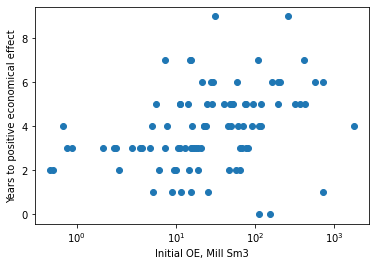

In [12]:
iniOE = []
pl_years = []
for dep in econSort:
    iniOE.append(dep['IniOE'])
    pl_years.append(dep['Plus CF'])
    
plt.figure()
plt.scatter(iniOE, pl_years)
plt.xscale('symlog')
plt.xlabel('Initial OE, Mill Sm3')
plt.ylabel('Years to positive economical effect')

#don't we see some log scale dependance?

Here we have to mention, that Dvalin deposit, which we marked as the least effective, is relatively new, and soon situation must change (as if economical effect is counted as curren cashflow). The effect of Vest Ekofisk looks very impressive, but once again - we did not use any data about expenses and other facts, so in real life situation is different.

Main conclusion I would like to do - quick overview over historical data may be interesting and usefull to find out some relations, which may help in estimations and transfering experience to your work case.